<a href="https://colab.research.google.com/github/asravankumar/END2.0/blob/master/session_6/encoder_decoder_tweets_sentiment_2_lstm_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
import pandas as pd

df = pd.read_csv("/content/tweets.csv")
df.head()

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1


In [150]:
df.shape

(1364, 2)

In [151]:
df.labels.value_counts()

0    931
1    352
2     81
Name: labels, dtype: int64

In [152]:
import random
import torch, torchtext
from torchtext import data

In [153]:
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [154]:
Tweet = torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [155]:
fields = [('tweet', Tweet), ('label', Label)]

In [156]:
example = [torchtext.legacy.data.Example.fromlist([df.tweets[i],df.labels[i]], fields) for i in range(df.shape[0])] 

In [157]:
twitterDataset = torchtext.legacy.data.Dataset(example, fields)

In [158]:
(train, valid) = twitterDataset.split(split_ratio=[85, 15], random_state = random.seed(SEED))

In [159]:
len(train), len(valid)

(1159, 205)

In [160]:
vars(train.examples[11])

{'label': 1,
 'tweet': ['@sweetbay',
  'That',
  'was',
  'Paul',
  'Ryan',
  "'s",
  'budget',
  '.',
  'How',
  'did',
  'Obama',
  "'s",
  'budget',
  'do',
  '?',
  'Getting',
  'educated',
  'on',
  'the',
  'facts',
  'is',
  'the',
  'first',
  'step',
  'in',
  'losing',
  'that',
  'liberalism',
  '!']}

In [161]:
Tweet.build_vocab(train)
Label.build_vocab(train)

In [162]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  4651
Size of label vocab :  3
Top 10 words appreared repeatedly : [('Obama', 1069), (':', 783), ('#', 780), ('.', 761), (',', 598), ('"', 550), ('the', 542), ('RT', 516), ('?', 419), ('to', 400)]
Labels :  defaultdict(None, {0: 0, 1: 1, 2: 2})


In [163]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [183]:
train_iterator, valid_iterator = torchtext.legacy.data.BucketIterator.splits((train, valid), batch_size = 5, 
                                                            sort_key = lambda x: len(x.tweet),
                                                            sort_within_batch=True, device = device)

In [165]:
next(iter(train_iterator))
#len(train.examples[11].tweet)


[torchtext.legacy.data.batch.Batch of size 5]
	[.tweet]:('[torch.LongTensor of size 5x28]', '[torch.LongTensor of size 5]')
	[.label]:[torch.LongTensor of size 5]

In [184]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

In [186]:
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    # Encoder class which accepts a sequence(tweet) and converts it into a context vector.
    super().__init__()

    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # RNN Layer for encoding
    self.rnn_layer = nn.RNN(embedding_dim,
                          hidden_dim,
                          batch_first=True)
    
  def forward(self, text, text_lengths):
    #print("inside encoder")
    # text = [batch size, sent_length]
    embedded_text         = self.embedding(text)

    #print("embedded text dimension", embedded_text.shape)
    # embedded = [batch size, sent_len, emb dim]

    # packed sequence
    packed_embedded_text  = nn.utils.rnn.pack_padded_sequence(embedded_text,
                                                        text_lengths.cpu(),
                                                        batch_first=True)
    #print("packed embedded text dimension", packed_embedded_text.data.shape)

    # input sequence to the rnn layer 
    encoder_output, hidden   = self.rnn_layer(packed_embedded_text)
    # rnn output in packed format which contains outputs at every sequence.
    # the hidden will be of last state only.
    # hidden = [1 , batch_size, hidden_dim]
    # Note that, the hidden tensor will not be in the batch_first = True shape. Only the output tensor will be in batch_first if it is set to true.
    # print("encoder output dimension", encoder_output.data.shape)
    #print("hidden dimension", hidden.shape)
    #print("hidden vector", hidden)

    # unpack the encoder rnn output 
    encoder_output, encoder_output_lengths = nn.utils.rnn.pad_packed_sequence(encoder_output, batch_first=True)
    # will be in batch_first = True shape
    # encoder_output = [batch_size, sent_len, hidden_dim]
    #print("encoder_output after pad packed dimension", encoder_output.shape)
    #print("--------------------------------------------------")

    # here returning the output at all states.
    # and the last hidden vector which is the SINGLE context vector for the input sequence. 
    return(encoder_output, hidden)

class Decoder(nn.Module):
  def __init__(self, encoder_output_dim, hidden_dim):
    super().__init__()

    # lstm layer as part of decoder.
    # the encoder emits a hidden vector with one sequence. Hence, lstm is here for once in the pipeline.

    self.decoder = nn.LSTM(encoder_output_dim, 
                       hidden_dim,  
                       batch_first=True)
    self.decoder2 = nn.LSTM(hidden_dim, 
                       hidden_dim,  
                       batch_first=True)

  def forward(self, single_vector):
    # Here single_vector is the hidden vector from the encoder.
    # single_vector = [batch_size, 1, hidden_dim]
    #print("inside decoder")
    #print("encoder output dimension", single_vector.shape)

    # encoder_output = encoder_output.squeeze(0).unsqueeze(1)
    # encoder_output
    output, (hidden_vector, cell_vector) = self.decoder(single_vector)
    # hidden_vector is the decoded vector which is input to the fully connected layer.
    # hidden_vector = [1, batch_size, hidden_dim]
    #print("decoded output dimension", output.shape)
    #print("decoded hidden vector dimension", hidden_vector.shape)
    #print("decoded cell vector dimension", cell_vector.shape)
    #print("-----------------")
    output2, (hidden_vector2, cell_vector2) = self.decoder2(output, (hidden_vector, cell_vector))
    #print("decoded output2 dimension", output2.shape)
    #print("decoded hidden2 vector dimension", hidden_vector.shape)
    #print("decoded cell2 vector dimension", cell_vector.shape)
    #print("---------------------------------------------------")
    return(output, output2, hidden_vector2)

class EncoderDecoderClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(EncoderDecoderClassifier, self).__init__()

    self.encoder = Encoder(vocab_size, embedding_dim, hidden_dim)
    self.decoder = Decoder(hidden_dim, hidden_dim)
    self.fc      = nn.Linear(hidden_dim, output_dim)

  def forward(self, text, text_lengths):
    # Encoder encodes using an rnn.
    encoder_output, encoder_hidden = self.encoder(text, text_lengths)

    # the hidden vector emitted by rnn is not in batch_first=True shape. Hence converting.
    #print("encoder hidden dimension", encoder_hidden.shape)
    # encoder_hidden = [1, batch_size, hidden_dim]
    encoder_hidden = encoder_hidden.squeeze(0).unsqueeze(1)
    #print("encoder output dimension after sqeeze", encoder_hidden.shape)
    # AFter reshaping
    # encoder_hidden = [batch_size, 1, hidden_dim]
    
    # Decode the input encoded single vector.
    decoder_output, decoder_output2, decoder_hidden = self.decoder(encoder_hidden)

    # the hidden vector emitted by the decoder is in the batch_first=False shape. Hence convert it to shape for linear layer.
    decoder_hidden = decoder_hidden.squeeze(0) #.unsqueeze(1)
    # input to fully connected layer dimension = [batch_size, hidden_dim]
    #print("input to fully connected layer", decoder_hidden.shape)
    dense_outputs = self.fc(decoder_hidden)
    # fully connected layer output = [batch_size, output_dim]
    #print("dense outputs", dense_outputs.shape)
    final_output = F.softmax(dense_outputs, dim=0)
    #print("final output", final_output.shape)
    return(final_output, encoder_output, encoder_hidden, decoder_output, decoder_output2)

In [187]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 3
num_layers = 2
dropout = 0.2

# Instantiate the model
model = EncoderDecoderClassifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes)
#model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [188]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

EncoderDecoderClassifier(
  (encoder): Encoder(
    (embedding): Embedding(4651, 300)
    (rnn_layer): RNN(300, 100, batch_first=True)
  )
  (decoder): Decoder(
    (decoder): LSTM(100, 100, batch_first=True)
    (decoder2): LSTM(100, 100, batch_first=True)
  )
  (fc): Linear(in_features=100, out_features=3, bias=True)
)
The model has 1,597,403 trainable parameters


In [170]:
batch = next(iter(train_iterator))
tweet, tweet_lengths = batch.tweet
print("tweet", tweet)
print("tweet lenghts", tweet_lengths)
model = model.to(device)
final_output, encoder_output, encoder_hidden, decoder_output, decoder_output2 = model(tweet, tweet_lengths)
print("final_output", final_output)
print("final output dimensions", final_output.shape)
print("---------------------------")

print("batch label", batch.label)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
loss = criterion(final_output, batch.label)
print("loss", loss)

tweet tensor([[   4,   29,   88,   37,    2,   16,   72, 4069,   73, 3251,   10,  657,
          274,   62, 1801,   19, 3641, 1869,    6,   59, 4063,  124],
        [   9,  862,    3,    2,  686,  654,   21,  710,  696, 1682, 1245, 1774,
         1723,   56, 1688,    4,   65,    4,  112,    4, 1580,    1],
        [   4,    2,  365,    7,  672,   19,  902,    7,  195,    4,  157,  199,
          313,    3, 3934, 1491,  174,    4,  433,    4, 3543,    1],
        [2315,   12,  127, 4346,   83,    3,    2,  190,   70,   35,  122,  182,
          236,  339,   68,   13,  137,   82,  506,   79, 3787,    1],
        [   4,  111, 1528,    2,  623,    8,  242,   73,    8,  907,    6,  100,
         1566,  772,  772,   22,  213,  149,   14,  212,    5,    1]])
tweet lenghts tensor([22, 21, 21, 21, 21])
final_output tensor([[0.1961, 0.2085, 0.1990],
        [0.2030, 0.1909, 0.1952],
        [0.2023, 0.1982, 0.1929],
        [0.1989, 0.1961, 0.2101],
        [0.1996, 0.2063, 0.2028]], grad_fn=<So

In [189]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [190]:
def train_model(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweet  
        
        # convert to 1D tensor
        predictions, encoder_output, encoder_hidden, decoder_output, decoder_output2 = model(tweet, tweet_lengths)
        predictions = predictions.squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [191]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweet
            
            # convert to 1d tensor
            #predictions = model(tweet, tweet_lengths).squeeze()
            
            predictions, encoder_output, encoder_hidden, decoder_output, decoder_output2 = model(tweet, tweet_lengths)
            predictions = predictions.squeeze()  
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [192]:
N_EPOCHS = 50
best_valid_loss = float('inf')
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train_model(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 1.095 | Train Acc: 50.50%
	 Val. Loss: 1.093 |  Val. Acc: 55.12% 

	Train Loss: 1.070 | Train Acc: 59.91%
	 Val. Loss: 1.065 |  Val. Acc: 58.05% 

	Train Loss: 1.029 | Train Acc: 65.06%
	 Val. Loss: 1.042 |  Val. Acc: 63.90% 

	Train Loss: 1.000 | Train Acc: 68.69%
	 Val. Loss: 1.037 |  Val. Acc: 64.88% 

	Train Loss: 0.985 | Train Acc: 73.00%
	 Val. Loss: 1.029 |  Val. Acc: 62.93% 

	Train Loss: 0.963 | Train Acc: 76.55%
	 Val. Loss: 1.029 |  Val. Acc: 64.88% 

	Train Loss: 0.963 | Train Acc: 76.96%
	 Val. Loss: 1.025 |  Val. Acc: 64.88% 

	Train Loss: 0.951 | Train Acc: 78.86%
	 Val. Loss: 1.018 |  Val. Acc: 68.78% 

	Train Loss: 0.951 | Train Acc: 80.17%
	 Val. Loss: 1.018 |  Val. Acc: 66.34% 

	Train Loss: 0.950 | Train Acc: 79.74%
	 Val. Loss: 1.017 |  Val. Acc: 64.88% 

	Train Loss: 0.942 | Train Acc: 80.34%
	 Val. Loss: 1.015 |  Val. Acc: 64.39% 

	Train Loss: 0.940 | Train Acc: 80.43%
	 Val. Loss: 1.014 |  Val. Acc: 65.37% 

	Train Loss: 0.938 | Train Acc: 82.84%
	

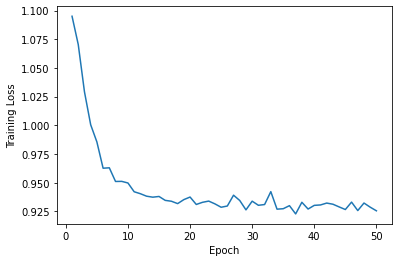

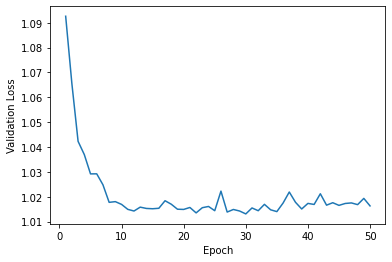

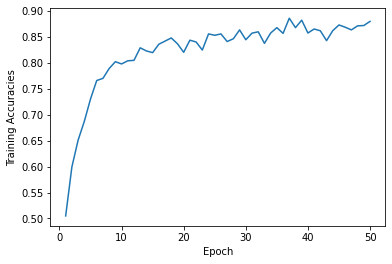

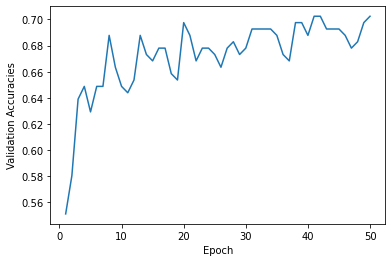

In [193]:
import matplotlib.pyplot as plt

plt.plot(list(range(1, len(train_losses) + 1)), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('training_loss.png')
plt.show()

plt.plot(list(range(1, len(valid_losses) + 1)), valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('valid_loss.png')
plt.show()

plt.plot(list(range(1, len(train_accuracies) + 1)), train_accuracies, label="Training Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracies")
plt.savefig('training_accuracies.png')
plt.show()

plt.plot(list(range(1, len(valid_accuracies) + 1)), valid_accuracies, label="Valid Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracies")
plt.savefig('validation_accuracies.png')
plt.show()

In [194]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet, print_vectors=False):
    
    categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]      
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction, encoder_output, encoder_hidden, decoder_output, decoder_output2 = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    if print_vectors:
      print("Encoder output after each token in the sequence:")
      for i in range(encoder_output.shape[1]):
        print("input word: \"" + tokenized[i] + "\"")
        print("encoding output vector:", encoder_output[0][i])
        print("--------")
      print("-----------------------------------------------")
      print("The Encoder final state hidden vector which is the single vector for sequence:")
      print("single vector", encoder_hidden)
      print("-----------------------------------------------")
      print("Decoder output after 1st step")
      print("decoder_output", decoder_output)
      print("-----------------------------------------------")
      print("Decoder output after 2nd step")
      print("decoder_output", decoder_output2)

      print("sizes of all vectors")
      print("encoder_output", encoder_output.shape)
      print("single vector", encoder_hidden.shape)
      print("decoder_output", decoder_output.shape)
      print("decoder_output2", decoder_output2.shape)
    return categories[pred.item()]

In [195]:
classify_tweet("#edshow Whenever Obama tells the truth about the Gop, they boo hoo hoo and call him a bully.", True)

Encoder output after each token in the sequence:
input word: "#"
encoding output vector: tensor([ 0.3184, -0.7582, -0.2498,  0.6358, -0.7074, -0.1639,  0.1268,  0.6927,
         0.3888,  0.9658,  0.0936, -0.9840, -0.3199,  0.2241,  0.2063, -0.9582,
         0.4742, -0.7685,  0.8296, -0.5967, -0.9885, -0.8501, -0.4127,  0.9805,
        -0.9958,  0.4343,  0.9408,  0.3124, -0.1117, -0.3498, -0.4366,  0.9794,
        -0.6898,  0.0073, -0.8230, -0.0485, -0.9717, -0.6958, -0.0212, -0.8098,
        -0.2424, -0.7672,  0.0356, -0.6456, -0.8653,  0.9758, -0.3249,  0.9766,
        -0.3139,  0.9506, -0.2566, -0.2896,  0.9861,  0.9350,  0.8717, -0.2761,
         0.7900, -0.9853,  0.8331,  0.5255,  0.8727, -0.7792, -0.3003, -0.7466,
        -0.0197,  0.7823,  0.9855,  0.6326,  0.2261,  0.2195,  0.8886, -0.7431,
         0.4201,  0.3087, -0.7448, -0.9645, -0.3026, -0.9567, -0.6131, -0.8406,
        -0.0513,  0.0021, -0.0968,  0.4702, -0.3302, -0.6279,  0.4357, -0.2746,
         0.7565, -0.5658, -0.23

'Negative'

In [178]:
vars(valid.examples[11])

{'label': 0,
 'tweet': ['@MalikFloyd',
  'Looks',
  'like',
  'Barack',
  'Obama',
  'in',
  'your',
  'twitcon',
  ',',
  'Lol',
  'Vute',
  'though',
  '&',
  'lt;3']}

In [179]:
index = 118
categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
tweet = ' '.join(vars(valid.examples[index])['tweet'])
print("tweet:", tweet)
print("predicted_class", classify_tweet(tweet))
print("labelled_class", categories[vars(valid.examples[index])['label']])

tweet: President Obama ^ Lindsay Lohan ^ 1989 RUMORS business 19 TH & M ST NW DC met field agent = multi connector to FFX VA covert overt zone .
predicted_class Negative
labelled_class Negative
